In [22]:
from frames import Frames
from audio import Audio
from label_map import label_map

import torch
# import torchvision.transforms as transforms
from torch.utils.data import Dataset

import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path


class OriginalMultimodalDataset(Dataset):
    """
    加载原始的多模态数据。
    """
    def __init__(self, is_need_audio=True, path_config_path_str='../configs/path.yaml'):
        # 导入配置。
        self.path_config = OmegaConf.load(path_config_path_str)

        # 加载视频、字幕、音频的路径。
        self.base_dir = Path(self.path_config['datasets']['base_dir'])
        self.base_video_dir = Path(self.path_config['datasets']['base_video_dir'])
        self.base_subtitle_dir = Path(self.path_config['datasets']['base_subtitle_dir'])
        self.base_audio_dir = Path(self.path_config['datasets']['base_audio_dir'])

        # 导入主控制文件。
        self.is_need_audio = is_need_audio
        self.all_data = pd.read_json(self.path_config['datasets']['base_all_data'], dtype={'video_id': str})

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        frames_data = self.get_frames_data(self.all_data.loc[idx, 'video_id'])
        result = {
            'title': self.all_data.loc[idx, 'title'],
            'emotion_name': self.all_data.loc[idx, 'emotion'],
            'emotion': label_map[self.all_data.loc[idx, 'emotion']],
            'scenes': frames_data['images'],
            'subtitles': frames_data['subtitles'],
        }
        if self.is_need_audio:
            audio_data = self.get_audio_data(self.all_data.loc[idx, 'video_id'])
            result = result | audio_data
        return result

    def get_frames_data(self, video_id):
        frames = Frames(video_id)
        video_info = frames.get_video_info()
        frames_image = frames.get_frame_image_by_time()
        frames_subtitle = frames.get_frame_subtitle_by_time()
        return {
            'images': frames_image,
            'subtitles': frames_subtitle
        }

    def get_audio_data(self, video_id):
        audio = Audio(video_id)
        waveform, sample_rate = audio.load_audio()
        return {
            'audio_waveform': waveform,
            'audio_sample_rate': sample_rate
        }


In [23]:
dataset = OriginalMultimodalDataset()

In [24]:
dataset[2]

{'title': '美导弹驱逐舰过航台湾海峡，东部战区：一切动向尽在掌握。',
 'emotion_name': '生气',
 'emotion': 6,
 'scenes': [array([[[195, 175,  91],
          [195, 175,  91],
          [195, 175,  91],
          ...,
          [178, 195, 226],
          [178, 195, 226],
          [178, 195, 226]],
  
         [[195, 175,  91],
          [195, 175,  91],
          [195, 175,  91],
          ...,
          [178, 195, 226],
          [178, 195, 226],
          [178, 195, 226]],
  
         [[198, 173,  90],
          [198, 173,  90],
          [198, 173,  90],
          ...,
          [178, 195, 226],
          [178, 195, 226],
          [178, 195, 226]],
  
         ...,
  
         [[213, 193, 207],
          [211, 191, 205],
          [211, 191, 205],
          ...,
          [217, 195, 209],
          [217, 195, 209],
          [218, 196, 210]],
  
         [[218, 198, 212],
          [218, 198, 212],
          [218, 198, 212],
          ...,
          [203, 181, 195],
          [203, 181, 195],
          [203, 181,

In [25]:
scenes = dataset[2]['scenes']

In [26]:
type(scenes)

list

In [27]:
len(scenes)

18

In [28]:
len(dataset[0]['scenes'])

8

In [29]:
type(scenes[0])

numpy.ndarray

In [30]:
scenes[0].shape

(1024, 576, 3)

In [31]:
scenes[0]

array([[[195, 175,  91],
        [195, 175,  91],
        [195, 175,  91],
        ...,
        [178, 195, 226],
        [178, 195, 226],
        [178, 195, 226]],

       [[195, 175,  91],
        [195, 175,  91],
        [195, 175,  91],
        ...,
        [178, 195, 226],
        [178, 195, 226],
        [178, 195, 226]],

       [[198, 173,  90],
        [198, 173,  90],
        [198, 173,  90],
        ...,
        [178, 195, 226],
        [178, 195, 226],
        [178, 195, 226]],

       ...,

       [[213, 193, 207],
        [211, 191, 205],
        [211, 191, 205],
        ...,
        [217, 195, 209],
        [217, 195, 209],
        [218, 196, 210]],

       [[218, 198, 212],
        [218, 198, 212],
        [218, 198, 212],
        ...,
        [203, 181, 195],
        [203, 181, 195],
        [203, 181, 195]],

       [[221, 201, 215],
        [221, 201, 215],
        [222, 202, 216],
        ...,
        [190, 168, 182],
        [191, 169, 183],
        [191, 169, 183]]

In [32]:
# from embedding import Captioner

In [33]:
# captioner = Captioner()

In [34]:
# caption = captioner.generate(scene[0])

In [35]:
# caption

In [36]:
from embedding import FaceExtractor

In [37]:
face_extractor = FaceExtractor()

In [38]:
faces = face_extractor.extract_face(scenes[0])

In [39]:
faces[0]

(<PIL.Image.Image image mode=RGB size=167x232>, 0.06568739149305555)

In [40]:
len(faces)

1

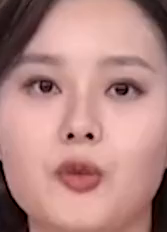

In [55]:
faces[0][0]

In [41]:
faces[0][0].size

(167, 232)

In [42]:
from embedding import ImageEncoder

In [43]:
image_encoder = ImageEncoder()

In [44]:
image_embedding = image_encoder.encode(scenes[0])

In [45]:
image_embedding

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.2806, -0.1873,  0.0766,  ..., -0.1090, -0.1649, -0.1197],
         [-0.3313, -0.1780,  0.0178,  ..., -0.2011, -0.1648, -0.1524],
         [-0.1896, -0.1854,  0.0531,  ..., -0.0340, -0.0930, -0.2985],
         ...,
         [-0.4313,  0.1011, -0.1071,  ..., -0.0052, -0.1496, -0.2253],
         [-0.3544,  0.0487, -0.1089,  ..., -0.0949, -0.1711, -0.2117],
         [-0.4008,  0.0174, -0.0661,  ..., -0.0246, -0.1063, -0.2650]]]), pooler_output=tensor([[ 8.6733e-02, -4.2666e-01, -2.8999e-01, -3.0547e-02, -2.4043e-01,
          2.0573e-01,  6.1655e-01,  3.1710e-01, -3.2083e-01, -5.8668e-01,
         -6.3054e-01,  3.4804e-01, -3.9066e-01,  2.7028e-01, -6.2365e-01,
          8.4195e-02, -3.9725e-01, -2.4332e-01, -3.1476e-01,  4.3178e-01,
         -3.3381e-01, -1.1414e-01,  2.8872e-01,  3.0764e-01,  3.8753e-01,
         -5.5268e-02,  2.2892e-01, -1.2904e-01,  6.4798e-01, -4.8539e-01,
          4.4030e-01,  2.3785e-01, -4.0404e-01,  1.558

In [49]:
vars(image_embedding)

{'last_hidden_state': tensor([[[-0.2806, -0.1873,  0.0766,  ..., -0.1090, -0.1649, -0.1197],
          [-0.3313, -0.1780,  0.0178,  ..., -0.2011, -0.1648, -0.1524],
          [-0.1896, -0.1854,  0.0531,  ..., -0.0340, -0.0930, -0.2985],
          ...,
          [-0.4313,  0.1011, -0.1071,  ..., -0.0052, -0.1496, -0.2253],
          [-0.3544,  0.0487, -0.1089,  ..., -0.0949, -0.1711, -0.2117],
          [-0.4008,  0.0174, -0.0661,  ..., -0.0246, -0.1063, -0.2650]]]),
 'pooler_output': tensor([[ 8.6733e-02, -4.2666e-01, -2.8999e-01, -3.0547e-02, -2.4043e-01,
           2.0573e-01,  6.1655e-01,  3.1710e-01, -3.2083e-01, -5.8668e-01,
          -6.3054e-01,  3.4804e-01, -3.9066e-01,  2.7028e-01, -6.2365e-01,
           8.4195e-02, -3.9725e-01, -2.4332e-01, -3.1476e-01,  4.3178e-01,
          -3.3381e-01, -1.1414e-01,  2.8872e-01,  3.0764e-01,  3.8753e-01,
          -5.5268e-02,  2.2892e-01, -1.2904e-01,  6.4798e-01, -4.8539e-01,
           4.4030e-01,  2.3785e-01, -4.0404e-01,  1.5586e-01, 

In [51]:
image_embedding.last_hidden_state.shape

torch.Size([1, 197, 768])

In [52]:
image_embedding.pooler_output.shape

torch.Size([1, 768])

In [46]:
face_embedding = image_encoder.encode(faces[0][0])

In [47]:
face_embedding

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.0306, -0.0640, -0.0923,  ..., -0.0857, -0.2353,  0.0656],
         [ 0.0945,  0.0453, -0.1007,  ..., -0.1388, -0.2363,  0.2144],
         [ 0.2016,  0.0955,  0.0686,  ..., -0.1767, -0.3175,  0.0784],
         ...,
         [ 0.1652, -0.1090, -0.2745,  ..., -0.1229, -0.3328, -0.0842],
         [ 0.1260, -0.0808, -0.2578,  ...,  0.0437, -0.2363,  0.1631],
         [ 0.0365, -0.2110, -0.0425,  ..., -0.0991, -0.2717,  0.1403]]]), pooler_output=tensor([[-0.2541, -0.2843, -0.1775,  0.6603, -0.3574, -0.3717,  0.5156,  0.3441,
         -0.2688, -0.3244,  0.2298,  0.4950, -0.5421,  0.3064, -0.1915,  0.4589,
          0.4676, -0.2751, -0.2498,  0.0515,  0.5773, -0.4441,  0.1611,  0.0710,
          0.4427, -0.0411,  0.3985, -0.4931,  0.0541,  0.0362,  0.0748,  0.3112,
          0.0773,  0.3157, -0.2386,  0.2711, -0.0562, -0.6103, -0.1336,  0.1147,
          0.0849, -0.4302, -0.5558,  0.5685,  0.1478, -0.1686, -0.6189, -0.0239,
         -0.

In [53]:
face_embedding.last_hidden_state.shape

torch.Size([1, 197, 768])

In [54]:
face_embedding.pooler_output.shape

torch.Size([1, 768])